# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# ⚽ Methodlogy
* In this notebook I'll demonstrate how to train **Unet** model using PyTorch.
* For mask I'll be using pre-computed mask from [here](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)
* As there are overlaps between **Stomach**, **Large Bowel** & **Small Bowel** classes, this is a **MultiLabel Segmentation** task, so final activaion should be `sigmoid` instead of `softmax`.
* For data split I'll be using **StratifiedGroupFold** to avoid data leakage due to `case` and to stratify `empty` and `non-empty` mask cases.
* You can play with different models and losses.

## Please Upvote if you Find this Useful :)

# 📒 Notebooks
📌 **UNet**:
* Train: [UWMGI: Unet [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/)
* Infer: [UWMGI: Unet [Infer] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-infer-pytorch/)

📌 **Data/Dataset**:
* Data: [UWMGI: Mask Data](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-data)
* Dataset: [UWMGI: Mask Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)

# 🛠 Install Libraries

In [1]:
# !pip install -q segmentation_models_pytorch
# !pip install -qU wandb
# !pip install -q scikit-learn==1.0

# 📚 Import Libraries 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

c:\Users\chris\anaconda3\envs\pytorch_f_cuda_11_7_umadison\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ⭐ WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

In [4]:
import wandb

wandb.login()

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
#     anonymous = None
# except:
#     anonymous = "must"
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cwinsor. Use `wandb login --relogin` to force relogin


True

# ⚙️ Configuration 

In [5]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    # zona originally train_bs=128
    train_bs      = 64
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 15
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# ❗ Reproducibility

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

* Files
    * train.csv - IDs and masks for all training objects.
    * sample_submission.csv - a sample submission file in the correct format
    * train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> Note that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * id - unique identifier for object
    * class - the predicted class for the object
    * EncodedPixels - RLE-encoded pixels for the identified object

In [7]:
# BASE_PATH  = '/kaggle/input/uw-madison-gi-tract-image-segmentation'

In [8]:
#linux df = pd.read_csv('/mnt/d/code_medimg_practice/medical_image_practice/03a_uw_madison/archive/train.csv')
df = pd.read_csv('D:\\code_medimg_practice\\medical_image_practice\\03a_uw_madison\\archive\\train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
#linux df['mask_path'] = df.mask_path.str.replace('/png/','/np/').str.replace('.png','.npy')
df['mask_path'] = df.mask_path.str.replace('\\png\\','\\np\\').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...,"[, , ]",0,True


In [9]:
print(df.loc[0,'image_path'])
print(df.loc[0,'mask_path'])

# linux BASE_PATH = '/mnt/d/code_medimg_practice/medical_image_practice/03a_uw_madison/archive/png/uw-madison-gi-tract-image-segmentation'
BASE_PATH = 'D:\\code_medimg_practice\\medical_image_practice\\03a_uw_madison\\archive\\png\\uw-madison-gi-tract-image-segmentation'
df['image_path'] = df['image_path'].map(lambda x: BASE_PATH + x.split('uw-madison-gi-tract-image-segmentation')[1])

# linux BASE_PATH = '/mnt/d/code_medimg_practice/medical_image_practice/03a_uw_madison/archive/np/uw-madison-gi-tract-image-segmentation'
BASE_PATH = 'D:\\code_medimg_practice\\medical_image_practice\\03a_uw_madison\\archive\\np\\uw-madison-gi-tract-image-segmentation'
df['mask_path'] = df['mask_path'].map(lambda x: BASE_PATH + x.split('uw-madison-gi-tract-image-segmentation')[1])

print(df.loc[0,'image_path'])
print(df.loc[0,'mask_path'])

/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
/kaggle/input/uwmgi-mask-dataset/png//uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.npy
D:\code_medimg_practice\medical_image_practice\03a_uw_madison\archive\png\uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png
D:\code_medimg_practice\medical_image_practice\03a_uw_madison\archive\np\uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.npy


In [10]:
# # df = pd.read_csv('../input/uwmgi-mask-dataset/train.csv')
# df = pd.read_csv('/mnt/d/code_medimg_practice/medical_image_practice/03a_uw_madison/archive/train.csv')
# df['segmentation'] = df.segmentation.fillna('')
# df['rle_len'] = df.segmentation.map(len) # length of each rle mask
# df['mask_path'] = df.mask_path.str.replace('/png/','/np/').str.replace('.png','.npy')

# df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
# df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

# df = df.drop(columns=['segmentation', 'class', 'rle_len'])
# df = df.groupby(['id']).head(1).reset_index(drop=True)
# df = df.merge(df2, on=['id'])
# df['empty'] = (df.rle_len==0) # empty masks
# df.head()

## Class Distribution

In [11]:
df['empty'].value_counts().plot.bar()

# 🔨 Utility

## Mask

In [12]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

## Image

In [13]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # zona formerly had tile
    # img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

## RLE

In [14]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 📁 Create Folds

In [15]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3257
      True     4551
1.0   False    3540
      True     4540
2.0   False    3053
      True     3923
3.0   False    3407
      True     4801
4.0   False    3333
      True     4091
Name: id, dtype: int64

# 🍚 Dataset

In [16]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        # print(f"zona0 - load_img index {index} img_path {img_path}",flush=True) 
        img = []
        img = load_img(img_path)
        
        if self.label:
            # print(f"zonaA - entering label {0}",flush=True) 
            msk_path = self.msk_paths[index]
            # print(f"zonaB - load_msk index {index} msk_path {msk_path}",flush=True) 
            msk = load_msk(msk_path)
            # print(f"zonaC1 - img.shape {img.shape} msk.shape {msk.shape}",flush=True)
            if self.transforms:
                # print(f"zonaC2 - applying transforms {0}",flush=True) 
                data = self.transforms(image=img, mask=msk)
                # print(f"zonaD - done w transforms {0}",flush=True)
                img  = data['image']
                msk  = data['mask']
                # print(f"zonaE - done 2 {0}",flush=True)
            # try:
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            # except Exception as inst:
            #     print("caught exception:")
            #     print(type(inst))    # the exception type
            #     print(inst.args)     # arguments stored in .args
            #     print(inst) 
            # print(f"zonaF - done w/ transpose img.shape {img.shape} msk.shape {msk.shape}",flush=True) 
            # print(f"zonaG - returning from label {0}\n",flush=True) 
            return torch.tensor(img), torch.tensor(msk)
        else:
            # print("zonaXXX - entering NOLABEL!",flush=True) 
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

# 🌈 Augmentations

In [17]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# 🍰 DataLoader

In [18]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    # zona - formerly had transforms
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])
    # train_dataset = BuildDataset(train_df)
    # valid_dataset = BuildDataset(valid_df)

    # zona - workers formerly 4
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=0, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [19]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [21]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 224, 224]), torch.Size([20, 3, 224, 224]))

# 📈 Visualization

In [22]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


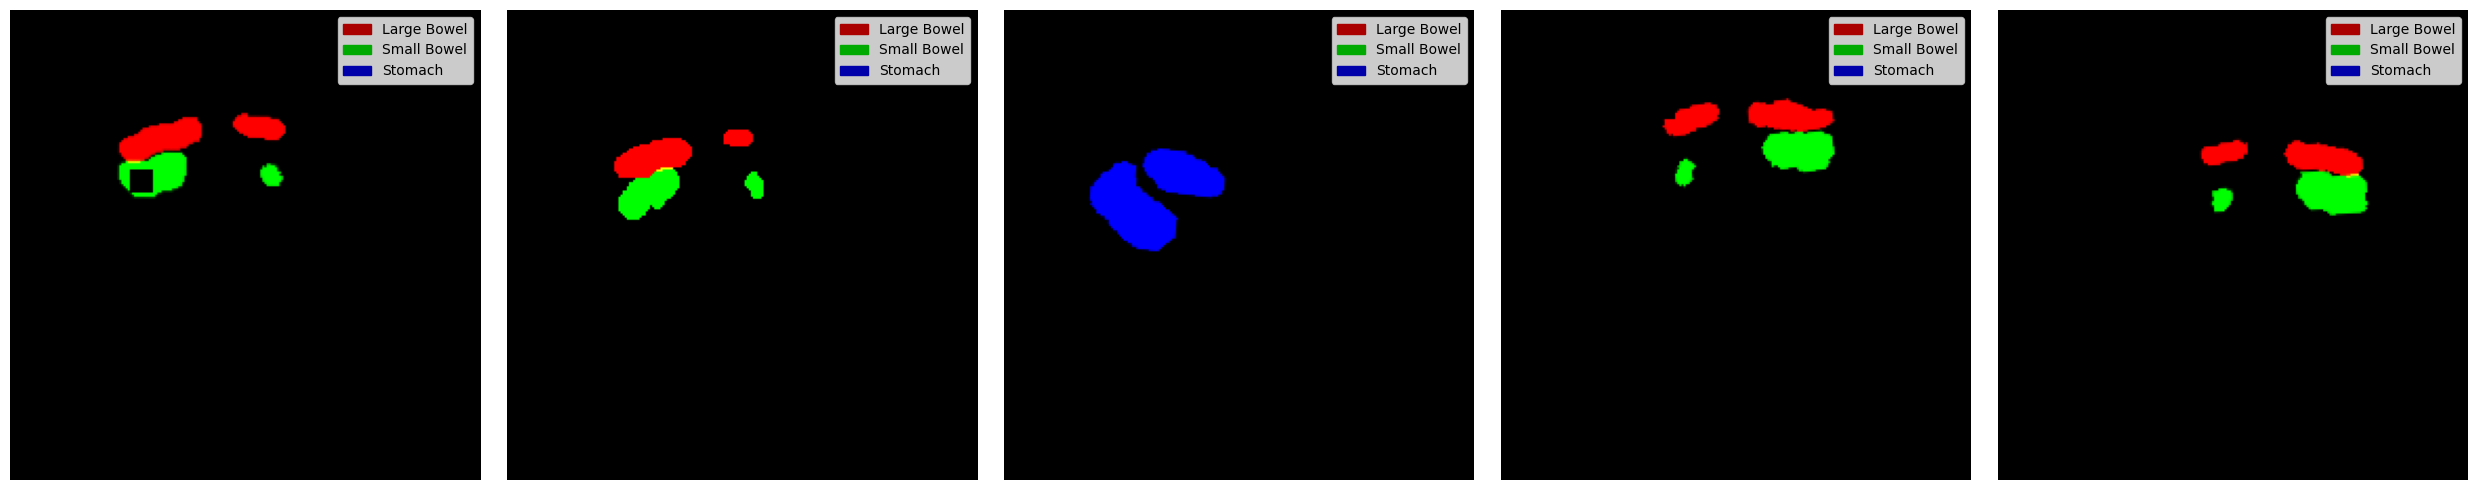

In [23]:
plot_batch(imgs, msks, size=5)

In [24]:
import gc
gc.collect()

12288

# 📦 Model


In [25]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# 🔧 Loss Function

In [26]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

# 🚄 Training Function

In [27]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [28]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [29]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [30]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [31]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to D:\TORCH_HOME\hub\checkpoints\efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 34.8MB/s]


# 🚅 Training

In [32]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous='never',
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3060

Epoch 1/15

Train :  20%|██        | 96/480 [07:42<30:51,  4.82s/it, gpu_mem=6.49 GB, lr=0.00200, train_loss=0.2391]


KeyboardInterrupt: 

# 🔭 Prediction

In [ ]:
test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), label=False, 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

In [ ]:
plot_batch(imgs, preds, size=5)

# ✂️ Remove Files

In [ ]:
!rm -r ./wandb